In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import plotly.express as ex

from tqdm.cli import tqdm
from glob import glob
from sklearn.manifold import TSNE
from plotly import express as ex
from os import path as pathlib,walk

%matplotlib inline

In [2]:
class Dataset(object):
    """
    Dataset wrapper to read images from folder and structure it.
    """
    def __init__(self,path,n_faces,resize=110):
        self.path = pathlib.abspath(path)
        self.resize = resize

    def __repr__(self,):
        return f"Dataset Parser @ {self.path}"
        
    def parse(self,progress_bar=True):
        w = walk(self.path)
        self.data = np.array([[[r,pathlib.join(r,f_)] for f_ in f] for r,_,f in list(w)[1:]]).reshape(-1,2)
        self.y = np.array(self.data[:,0])
        self.x = np.array([
            cv2.cvtColor(
                cv2.resize(
                    cv2.imread(
                        i
                    ),
                    (self.resize,self.resize)
                ),
                cv2.COLOR_BGR2RGB
            ) / 255
            for 
                i
            in 
                (tqdm(self.data[:,1]) if progress_bar else self.data[:,1])
        ]).astype(np.float32)
        return self
            

In [3]:
dataset = Dataset("./images/train/",100)

In [4]:
dataset.parse(progress_bar=1)

100%|██████████| 450/450 [00:01<00:00, 400.80it/s]


Dataset Parser @ /storage/facedet_cap/notebooks/images/train

In [5]:
dataset

Dataset Parser @ /storage/facedet_cap/notebooks/images/train

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,Callback

### Base Network

<!-- |layer  | size-in    | size-out   | kernel     | param | FLPS |
|-------|------------|------------|------------|-------|------|
|conv1  | 220×220×3  | 110×110×64 | 7×7×3, 2   | 9K    |115M  |
|pool1  | 110×110×64 | 55×55×64   | 3×3×64, 2  | 0     |      |
|rnorm1 | 55×55×64   | 55×55×64   | 0          |       |      |
|conv2a | 55×55×64   | 55×55×64   | 1×1×64, 1  | 4K    | 13M  |
|conv2  | 55×55×64   | 55×55×192  | 3×3×64, 1  | 111K  | 335M |
|rnorm2 | 55×55×192  | 55×55×192  | 0          |       |      |
|pool2  | 55×55×192  | 28×28×192  | 3×3×192, 2 | 0     |      |
|conv3a | 28×28×192  | 28×28×192  | 1×1×192, 1 | 37K   | 29M  |
|conv3  | 28×28×192  | 28×28×384  | 3×3×192, 1 | 664K  | 521M |
|pool3  | 28×28×384  | 14×14×384  | 3×3×384, 2 | 0     |      |
|conv4a | 14×14×384  | 14×14×384  | 1×1×384, 1 | 148K  | 29M  |
|conv4  | 14×14×384  | 14×14×256  | 3×3×384, 1 | 885K  | 173M |
|conv5a | 14×14×256  | 14×14×256  | 1×1×256, 1 | 66K   | 13M  |
|conv5  | 14×14×256  | 14×14×256  | 3×3×256, 1 | 590K  | 116M |
|conv6a | 14×14×256  | 14×14×256  | 1×1×256, 1 | 66K   | 13M  |
|conv6  | 14×14×256  | 14×14×256  | 3×3×256, 1 | 590K  | 116M |
|pool4  | 14×14×256  | 7×7×256    | 3×3×256, 2 | 0     |      |
|concat | 7×7×256    | 7×7×256    | 0          |       |      |
|fc1    | 7×7×256    | 1×32×128   | maxout p=2 | 103M  | 103M |
|fc2    | 1×32×128   | 1×32×128   | maxout p=2 | 34M   | 34M  |
|fc7128 | 1×32×128   | 1×1×128    | 524K 0.5M  |       |      |
|L2     | 1×1×128    | 1×1×128    | 0          |       |      | -->

In [83]:
d = 64

In [84]:
def base_network(d=d):
    
    activation = 'swish'
    _input = Input(shape=(110,110,3))

    a_conv0 = Conv2D(32,3,activation=activation,padding="same")(_input)
    a_conv1 = Conv2D(32,3,activation=activation,padding="same")(a_conv0)
    a_conv2 = Conv2D(32,3,activation=activation,padding="same")(a_conv1)
    a_conc = concatenate([a_conv0,a_conv1,a_conv2])
    a_pool = MaxPool2D()(a_conc)

    b_conv0 = Conv2D(32,3,activation=activation,padding="same")(a_pool)
    b_conv1 = Conv2D(32,3,activation=activation,padding="same")(b_conv0)
    b_conv2 = Conv2D(32,3,activation=activation,padding="same")(b_conv1)
    b_conc = concatenate([a_pool,b_conv0,b_conv1,b_conv2])
    b_pool = MaxPool2D()(b_conc)

    c_conv0 = Conv2D(64,3,activation=activation,padding="same")(b_pool)
    c_conv1 = Conv2D(64,3,activation=activation,padding="same")(c_conv0)
    c_conv2 = Conv2D(64,3,activation=activation,padding="same")(c_conv1)
    c_conc = concatenate([b_pool,c_conv0,c_conv1,c_conv2])
    c_pool = MaxPool2D()(c_conc)

    d_conv0 = Conv2D(64,3,activation=activation,padding="same")(c_pool)
    d_conv1 = Conv2D(64,3,activation=activation,padding="same")(d_conv0)
    d_conv2 = Conv2D(64,3,activation=activation,padding="same")(d_conv1)
    d_conc = concatenate([c_pool,d_conv0,d_conv1,d_conv2])
    d_pool = MaxPool2D()(d_conc)

    e_conv0 = Conv2D(128,3,activation=activation,padding="same")(d_pool)
    e_conv1 = Conv2D(128,3,activation=activation,padding="same")(e_conv0)
    e_conv2 = Conv2D(128,3,activation=activation,padding="same")(e_conv1)
    e_conc = concatenate([d_pool,e_conv0,e_conv1,e_conv2])
    e_pool = MaxPool2D()(e_conc)

    f_conv0 = Conv2D(128,3,activation="relu",padding="same")(e_pool)
    f_conv1 = Conv2D(128,3,activation="relu",padding="same")(f_conv0)
    f_conv2 = Conv2D(128,3,activation="relu",padding="same")(f_conv1)
    f_conc = concatenate([f_conv0,f_conv1,f_conv2])
    f_pool = MaxPool2D()(f_conc)

    dense = Flatten()(f_pool)
    dense = Dense(512,activation="linear")(dense)
    dense = Dense(d,activation="tanh")(dense)

    dense = tf.multiply(dense,d)
    
    model = keras.Model(_input,dense)
    return model

### Pairs

In [85]:
class Pairs(object):
    def __init__(self,model:tf.keras.Model,x:np.ndarray,y:np.ndarray,size:int=110):
        assert len(x) == len(y)
        self.x = x.reshape(-1,*x[0].shape[:2],3)
        self.y = y
        self.model = model
        self.dummy = np.array([[0]])
        self.size = size
        
    def get_pair(self,e,x,y):
        a = x.reshape(1,self.size,self.size,3)
        
        p_index = np.where(self.y == y)
        n_index = np.where(self.y != y)

        p = self.epoch_enc[p_index]
        n = self.epoch_enc[n_index]

        p_dist = np.sum(np.square(p - e),axis=1).argmax()
        n_dist = np.sum(np.square(n - e),axis=1).argmin()

        p = self.x[p_index][p_dist].reshape(1,self.size,self.size,3)
        n = self.x[n_index][n_dist].reshape(1,self.size,self.size,3)
        
        return np.array([a,p,n])
        
    def flow(self,epochs=1):
        for epoch in range(epochs):
            self.epoch_enc = self.model.predict(self.x,batch_size=600)
            _iter = zip(self.epoch_enc,self.x,self.y)
            for e,x,y in _iter:
                yield (*self.get_pair(e,x,y),),self.dummy
                
class PairsBatched(object):
    def __init__(self,model:tf.keras.Model,x:np.ndarray,y:np.ndarray,size:int=110):
        self.x = x.reshape(-1, 110, 110, 3)
        self.y = y
        self.model = model
        self.size = size
        
        self.dummy = np.array([[0]])
        
    def get_pair(self,e,x,y):
        a = x.reshape(1,self.size,self.size,3)
        
        p_index = np.where(self.y == y)
        n_index = np.where(self.y != y)

        p = self.epoch_enc[p_index]
        n = self.epoch_enc[n_index]

        p_dist = np.sum(np.square(p - e),axis=1).argmax()
        n_dist = np.sum(np.square(n - e),axis=1).argmin()

        p = self.x[p_index][p_dist].reshape(1,self.size,self.size,3)
        n = self.x[n_index][n_dist].reshape(1,self.size,self.size,3)
        
        return np.array([a,p,n])
        
    def flow(self,):
        while True:
            self.epoch_enc = self.model.predict(self.x,batch_size=60)
            pairs = np.array([ self.get_pair(e,x,y) for e,x,y in  zip(self.epoch_enc,self.x,self.y) ])
            return pairs


In [86]:
model = base_network()
pairs = Pairs(model,dataset.x,dataset.y)
flow = pairs.flow()

In [87]:
# fig,axes = plt.subplots(3,3,figsize=(12,12))

# for ax in axes:
#     (a,p,n),r = next(flow)
#     ax[0].imshow(a.reshape(110,110,3))
#     ax[1].imshow(p.reshape(110,110,3))
#     ax[2].imshow(n.reshape(110,110,3))

### Triplet Loss

In [88]:
class Triplet(tf.Module):
    """
    Triplet Loss
    """
    __name__ = "TripletLoss"
    def __init__(self,margin=.75):
        self.margin = margin
        
    @tf.function
    def l2(self,x,y):
        return tf.reduce_sum(tf.square(tf.subtract(x,y)))
    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        a,p,n = tf.unstack(tf.reshape(y_pred,(3,-1,d)))
        
        Dp = self.l2(a,p)
        Dn = self.l2(a,n)
        
        return tf.nn.relu(Dp - Dn + self.margin)

In [89]:
model = base_network()

a_inp = Input(shape=(110,110,3),name="anc")
p_inp = Input(shape=(110,110,3),name="pos")
n_inp = Input(shape=(110,110,3),name="neg")

a_net = model(a_inp)
p_net = model(p_inp)
n_net = model(n_inp)

out = concatenate([a_net,p_net,n_net],name="out")
train = keras.Model([a_inp,p_inp,n_inp],out)

In [90]:
pairs = Pairs(model,dataset.x,dataset.y)
opt = keras.optimizers.Adagrad(.0001)
triplet = Triplet(margin=8)
train.compile(optimizer=opt,loss=triplet)

In [91]:
epochs = 230
flow = pairs.flow(epochs=epochs)

In [92]:
history = train.fit_generator(flow,steps_per_epoch=len(dataset.x),epochs=epochs)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/230
450/450 [==============================] - 19s 37ms/step - loss: 11.8636
Epoch 2/230
450/450 [==============================] - 17s 37ms/step - loss: 9.5820
Epoch 3/230
450/450 [==============================] - 17s 37ms/step - loss: 9.0148
Epoch 4/230
450/450 [==============================] - 17s 37ms/step - loss: 8.7965
Epoch 5/230
450/450 [==============================] - 17s 37ms/step - loss: 8.6433
Epoch 6/230
450/450 [==============================] - 17s 37ms/step - loss: 8.5378
Epoch 7/230
450/450 [==============================] - 17s 36ms/step - loss: 8.5209
Epoch 8/230
450/450 [==============================] - 17s 36ms/step - loss: 8.4235
Epoch 9/230
450/450 [==============================] - 17s 37ms/step - loss: 8.4106
Epoch 10/230
450/450 [==============================] - 17s 37ms/step - loss: 8.3169
Epoch 11/230
450/450 [==============================] - 17s 37ms/step - loss: 8.3861
Epoch 12/230
450/450 [==============================] - 17s 37ms/step - l

In [95]:
pred = model.predict(dataset.x,batch_size=32)
tsne = TSNE(2,)
proj = tsne.fit_transform(pred)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Clusters')

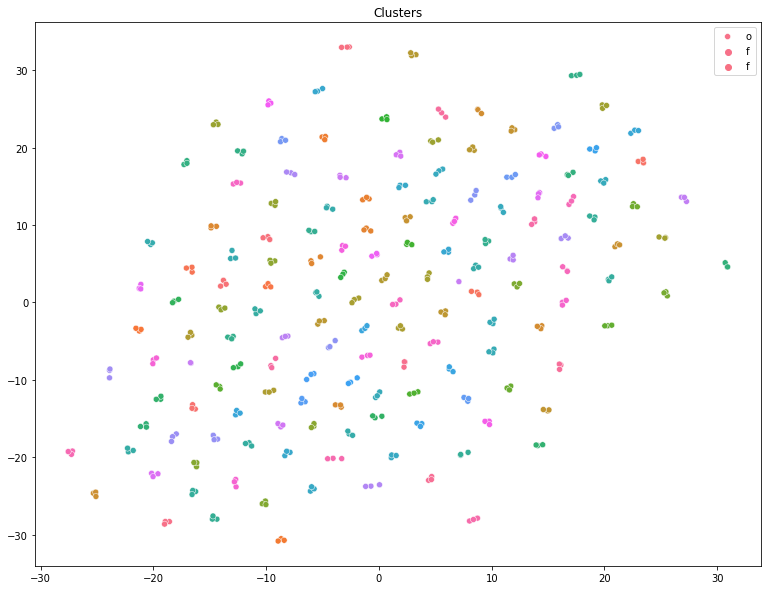

In [96]:
fig = plt.figure(figsize=(13,10))
sns.scatterplot(proj[:,0],proj[:,1],hue=dataset.y,)
plt.legend("off")
plt.title("Clusters")

In [97]:
model.save("./model/")

INFO:tensorflow:Assets written to: ./model/assets
